In [1]:
import pymysql
import pandas as pd
import re
import numpy as np

In [2]:
def connectDatabase():
    db = pymysql.connect('localhost',
                         'root',
                         '940803',
                         'IAC2.0')
    return db

def queryDatabase(db, tableName):
    cursor = db.cursor()
    sql = 'SELECT * FROM %s' % tableName
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        return results
    except:
        print('Error: unable to fetch data')

In [3]:
def cleanText(text):
    text = ' '.join([word for word in text.strip().split()])
    text = re.sub(r"[^\x00-\x7f]", '', text)
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`.]", " ", text)
    text = re.sub(r",{1,}", " , ", text)
    text = re.sub(r"\.{1,}", " . ", text)
    text = re.sub(r"!{1,}", " ! ", text)
    text = re.sub(r"\({1,}", " ( ", text)
    text = re.sub(r"\){1,}", " ) ", text)
    text = re.sub(r"\?{1,}", " ? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip().lower()

In [4]:
def dataResolution(results, tableName):
    dataResults = []
    if tableName == 'mturk_2010_qr_entry':
        for row in results:
            pageID = str(row[0])
            tabNum = str(row[1])
            qrID = pageID + '@' +tabNum
            quoteText = cleanText(str(row[6]))
            responseText = cleanText(str(row[7]))
            topic = str(row[9])
            dataResults.append([qrID, quoteText, responseText, topic])
        return dataResults

    if tableName == 'mturk_2010_qr_task1_average_response':
        for row in results:
            pageID = str(row[0])
            tabNum = str(row[1])
            qrID = pageID + '@' + tabNum

            disagree_agree = float(row[3])
            attacking_respectful = float(row[5])
            emotion_fact = float(row[7])
            nasty_nice = float(row[9])

            dataResults.append([qrID, disagree_agree, attacking_respectful, emotion_fact, nasty_nice])
        return dataResults

    if tableName == 'post':
        for row in results:
            discussionID = str(row[0])
            postID = str(row[1])
            textID = str(row[6])
            dataResults.append([discussionID+'@'+postID, textID])
        return dataResults

    if tableName == 'quote':
        for row in results:
            quoteTextID = str(row[5])
            responseDPID = str(row[0]) + '@' + str(row[1]) # discussionID + postID
            dataResults.append([quoteTextID, responseDPID])
        return dataResults

    if tableName == 'text':
        for row in results:
            textID = str(row[0])
            text = cleanText(str(row[1]))
            dataResults.append([textID, text])
        return dataResults

In [5]:
def get_qrID2Label(qrPairLabelList):
    qrID2Label = dict()
    for row in qrPairLabelList:
        qrID = row[0]
        qrID2Label[qrID] = row[1:]
    return qrID2Label

In [6]:
db = connectDatabase()
qrPairList = queryDatabase(db, 'mturk_2010_qr_entry')
qrPairList = dataResolution(qrPairList, 'mturk_2010_qr_entry')
qrPairList[:10]

[['1@0',
  'i got a good idea . however , they do tend to stay with their own .',
  "by your own admission you havent 'hung out' with stoners for a while and you're making generalisations about them to people who do spend a lot of time with stoners ?",
  'marijuana legalization'],
 ['1@1',
  "be sure to give your guns a big fat kiss tonight before you go to bed tonight 'cuz guns did really good today .",
  "actually , they didn't . the whole tragedy was caused by gun control . if even one student was packing when that occured , 33 lives could have been saved . but no , more victims of botched laws and corrupt politicians .",
  'gun control'],
 ['1@2',
  "one of the biggest arguments against gun control is that if the government became too oppressive , the people wouldn't have the capacity to carry out a successful rebellion . of course , if the government was becoming oppressive , it would likely implement gun control , so the absence of gun control is necessary to ensure that we do no

In [7]:
qrPairLabelList = queryDatabase(db, 'mturk_2010_qr_task1_average_response')
qrPairLabelList = dataResolution(qrPairLabelList, 'mturk_2010_qr_task1_average_response')

qrID2Label = get_qrID2Label(qrPairLabelList)

In [8]:
result = []
for row in qrPairList:
    qrID = row[0]
    try:
        label = qrID2Label[qrID]
        row.extend(label)
        result.append(row)
    except Exception:
        pass
qrPair_df = pd.DataFrame(result, columns=['qrID', 'quoteText', 'responseText', 'topic', 'disagree_agree', 'attacking_respectful', 'emotion_fact', 'nasty_nice'])
#qrPair_df.to_csv('./data/qrPair_2018.csv', index=None)

In [9]:
qrPair_df

,qrID,quoteText,responseText,topic,disagree_agree,attacking_respectful,emotion_fact,nasty_nice
0,1@0,"i got a good idea . however , they do tend to ...",by your own admission you havent 'hung out' wi...,marijuana legalization,-2.200000,0.000000,-3.200000,1.400000
1,1@1,be sure to give your guns a big fat kiss tonig...,"actually , they didn't . the whole tragedy was...",gun control,-3.400000,0.800000,-0.400000,2.000000
2,1@2,one of the biggest arguments against gun contr...,not quite . to be more correct regarding gover...,gun control,-3.400000,1.200000,3.000000,2.200000
3,1@3,"first of all , compare the b specimen in your ...",at your service comparison i could've just cir...,evolution,-2.600000,1.200000,0.200000,1.200000
4,1@4,there are some incedents that are beyond your ...,well yes .,gun control,3.400000,3.200000,-1.600000,2.400000
5,1@5,so the answer to your question is that there i...,"so which is it the action is moral , the actio...",abortion,-1.000000,0.200000,0.000000,0.200000
6,1@6,legality does not matter . religous implicatio...,"exact , to the point , amp beautiful .",abortion,3.400000,3.400000,-2.000000,3.400000
7,2@0,it can go both ways . we all doubt . it is wha...,true .,evolution,4.400000,3.800000,-0.800000,3.800000
8,2@1,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,abortion,0.800000,1.200000,-1.800000,2.200000
9,2@2,"i personly would not condone an abortion , how...","this is a pretty touchy issue , and i agree wi...",abortion,3.400000,4.000000,-2.600000,3.800000


In [10]:
def rowFilter(row):
    quoteText = [word for word in str(row['quoteText']).split() if word != '']
    responseText = [word for word in str(row['responseText']).split() if word != '']
    if len(quoteText) > 0 and len(responseText) > 0:
        filterLabel = False
    else:
        filterLabel = True
    row['filterLabel'] = filterLabel
    return row

In [11]:
print(len(qrPair_df))
qrPair_df = qrPair_df.apply(rowFilter, axis=1)
qrPair_df = qrPair_df[qrPair_df.filterLabel == False]
print(len(qrPair_df))

9982
9982


In [12]:
qrPair_df

,qrID,quoteText,responseText,topic,disagree_agree,attacking_respectful,emotion_fact,nasty_nice,filterLabel
0,1@0,"i got a good idea . however , they do tend to ...",by your own admission you havent 'hung out' wi...,marijuana legalization,-2.200000,0.000000,-3.200000,1.400000,False
1,1@1,be sure to give your guns a big fat kiss tonig...,"actually , they didn't . the whole tragedy was...",gun control,-3.400000,0.800000,-0.400000,2.000000,False
2,1@2,one of the biggest arguments against gun contr...,not quite . to be more correct regarding gover...,gun control,-3.400000,1.200000,3.000000,2.200000,False
3,1@3,"first of all , compare the b specimen in your ...",at your service comparison i could've just cir...,evolution,-2.600000,1.200000,0.200000,1.200000,False
4,1@4,there are some incedents that are beyond your ...,well yes .,gun control,3.400000,3.200000,-1.600000,2.400000,False
5,1@5,so the answer to your question is that there i...,"so which is it the action is moral , the actio...",abortion,-1.000000,0.200000,0.000000,0.200000,False
6,1@6,legality does not matter . religous implicatio...,"exact , to the point , amp beautiful .",abortion,3.400000,3.400000,-2.000000,3.400000,False
7,2@0,it can go both ways . we all doubt . it is wha...,true .,evolution,4.400000,3.800000,-0.800000,3.800000,False
8,2@1,"once again , you seem to support the killing o...",based on the idea that people are dispensible ...,abortion,0.800000,1.200000,-1.800000,2.200000,False
9,2@2,"i personly would not condone an abortion , how...","this is a pretty touchy issue , and i agree wi...",abortion,3.400000,4.000000,-2.600000,3.800000,False


In [13]:
print(len(qrPair_df))
qrPair_df = qrPair_df.dropna(axis=0, how='any')
print(len(qrPair_df))

9982
9982


In [1]:
import pandas as pd
import collections

In [13]:
# train_df = pd.read_csv('./data/create_debate_train.csv')

In [17]:
qrPair_df = pd.read_csv('./data/debatepedia_agreement_dataset.csv', header=None, usecols=range(7), names=['pair_id', 'relation', 'topic', 'debate_title', 'debate_subtitle', 'Snippet_A', 'Snippet_B']) # data on server
import re
def cleanText(text):
    text = str(text)
    text = ' '.join([word for word in text.strip().split()])
    text = re.sub(r'[^\x00-\x7f]', '', text)
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " \( ", text)
    text = re.sub(r"\)", " \) ", text)
    text = re.sub(r"\?", " \? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip().lower()
qrPair_df['quoteText'] = qrPair_df['Snippet_A'].apply(cleanText)
qrPair_df['responseText'] = qrPair_df['Snippet_B'].apply(cleanText)
train_df = qrPair_df

In [18]:
train_df

,pair_id,relation,topic,debate_title,debate_subtitle,Snippet_A,Snippet_B,quoteText,responseText
0,1,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700 bailout wrongly trusts culprits to solve ...,700b bailout helps avoid widespread bankruptci...,700 bailout wrongly trusts culprits to solve c...
1,2,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700 billion bailout plan is too little too la...,700b bailout helps avoid widespread bankruptci...,700 billion bailout plan is too little too lat...
2,3,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700b bailout would increase US deficit and in...,700b bailout helps avoid widespread bankruptci...,700b bailout would increase us deficit and int...
3,4,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,No assurances that a $700b bailout would work ...,700b bailout helps avoid widespread bankruptci...,no assurances that a 700b bailout would work s...
4,5,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700 bailout wrongly trusts culprits to solve ...,700b bailout is generally well designed to sol...,700 bailout wrongly trusts culprits to solve c...
5,6,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700 billion bailout plan is too little too la...,700b bailout is generally well designed to sol...,700 billion bailout plan is too little too lat...
6,7,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700b bailout would increase US deficit and in...,700b bailout is generally well designed to sol...,700b bailout would increase us deficit and int...
7,8,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,No assurances that a $700b bailout would work ...,700b bailout is generally well designed to sol...,no assurances that a 700b bailout would work s...
8,9,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is important to stabilize volati...,$700 bailout wrongly trusts culprits to solve ...,700b bailout is important to stabilize volatil...,700 bailout wrongly trusts culprits to solve c...
9,10,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is important to stabilize volati...,$700 billion bailout plan is too little too la...,700b bailout is important to stabilize volatil...,700 billion bailout plan is too little too lat...


In [19]:
print(collections.Counter(train_df.relation.values).most_common())

[('disagreement', 15279), ('agreement', 14025)]


In [20]:
train_df['quoteLen'] = train_df['quoteText'].apply(lambda text: len([word for word in str(text).split() if word != '']))
train_df['responseLen'] = train_df['responseText'].apply(lambda text: len([word for word in str(text).split() if word != '']))

In [21]:
train_df

,pair_id,relation,topic,debate_title,debate_subtitle,Snippet_A,Snippet_B,quoteText,responseText,quoteLen,responseLen
0,1,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700 bailout wrongly trusts culprits to solve ...,700b bailout helps avoid widespread bankruptci...,700 bailout wrongly trusts culprits to solve c...,41,101
1,2,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700 billion bailout plan is too little too la...,700b bailout helps avoid widespread bankruptci...,700 billion bailout plan is too little too lat...,41,105
2,3,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,$700b bailout would increase US deficit and in...,700b bailout helps avoid widespread bankruptci...,700b bailout would increase us deficit and int...,41,157
3,4,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout helps avoid widespread bankruptc...,No assurances that a $700b bailout would work ...,700b bailout helps avoid widespread bankruptci...,no assurances that a 700b bailout would work s...,41,44
4,5,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700 bailout wrongly trusts culprits to solve ...,700b bailout is generally well designed to sol...,700 bailout wrongly trusts culprits to solve c...,53,101
5,6,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700 billion bailout plan is too little too la...,700b bailout is generally well designed to sol...,700 billion bailout plan is too little too lat...,53,105
6,7,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,$700b bailout would increase US deficit and in...,700b bailout is generally well designed to sol...,700b bailout would increase us deficit and int...,53,157
7,8,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is generally well designed to so...,No assurances that a $700b bailout would work ...,700b bailout is generally well designed to sol...,no assurances that a 700b bailout would work s...,53,44
8,9,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is important to stabilize volati...,$700 bailout wrongly trusts culprits to solve ...,700b bailout is important to stabilize volatil...,700 bailout wrongly trusts culprits to solve c...,62,101
9,10,disagreement,bailout,"Debate: $700 billion US economic bailout, Deba...","Economics: Is the $700b ""bailout"" economically...",$700b bailout is important to stabilize volati...,$700 billion bailout plan is too little too la...,700b bailout is important to stabilize volatil...,700 billion bailout plan is too little too lat...,62,105


In [22]:
import matplotlib.pyplot as plt

In [23]:
train_df.quoteLen.describe()

count    29304.000000
mean        82.720994
std         55.427349
min          2.000000
25%         47.000000
50%         73.000000
75%        107.000000
max        837.000000
Name: quoteLen, dtype: float64

In [24]:
train_df.responseLen.describe()

count    29304.000000
mean        76.772318
std         51.998478
min          1.000000
25%         43.000000
50%         68.000000
75%        102.000000
max        837.000000
Name: responseLen, dtype: float64

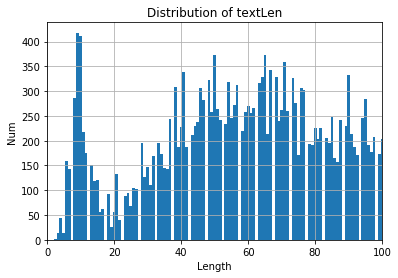

In [25]:
train_df.quoteLen.hist(bins=1000)
plt.xlim(0, 100)
plt.xlabel('Length')
plt.ylabel('Num')
plt.title('Distribution of textLen')
plt.show()

In [3]:
for i in range(2, 5):
    print(i)

2
3
4
